In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "/home/jovyan/work/heat_eq/analysis/figures/"

In [3]:
# constants
a = 7.5408e-2
b = 1.7692e-4
c = 3.6142e-8
d = 6.400e9*np.sqrt(1000)
e = 1.635e4
f = 2*c
g = 1.60e8*np.sqrt(1000)
h = 1.0464e12*np.sqrt(1000)

k = lambda T : 1/(a + b*T + c*T**2) + d * np.exp(-e/T) / T**(5/2)
# https://www.nuclear-power.com/nuclear-engineering/heat-transfer/thermal-conduction/thermal-conductivity/thermal-conductivity-of-uranium-dioxide/

In [4]:
T_ext = 273.15 + 800
T_max = 2800 + 273.15
resolution = 1000
T = np.linspace(T_ext, T_max, resolution)
cond = k(T)

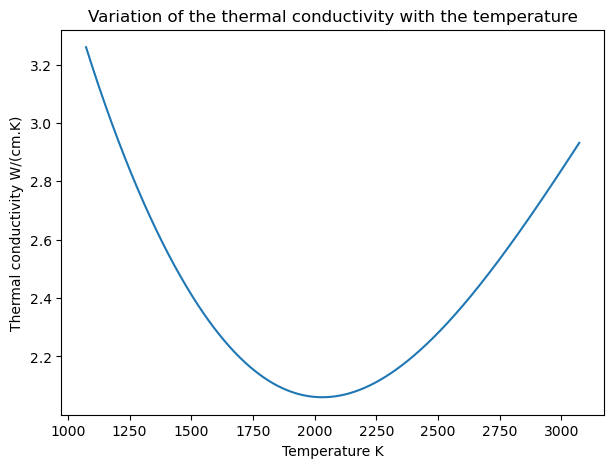

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(T, cond)
ax.set_title("Variation of the thermal conductivity with the temperature")
ax.set_ylabel('Thermal conductivity W/(cm.K)')
ax.set_xlabel('Temperature K')
plt.savefig(f"{path}_k0")

In [6]:
dkdr =  lambda T : \
            -(b + f*T) / (a + b*T + c*T**2)**2 \
            - g * np.exp(-e/T) / (np.sign(T)*(np.abs(T))**(7/2)) \
            + h * np.exp(-e/T) / (np.sign(T)*(np.abs(T))**(9/2))

In [7]:
k_slope = dkdr(T)

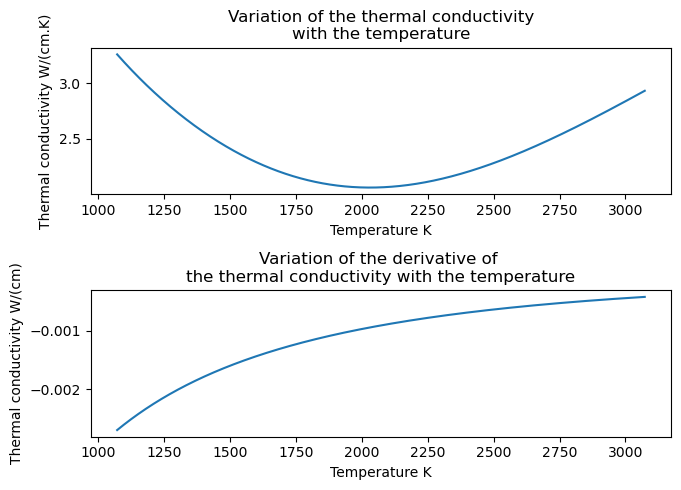

In [8]:
fig, ax = plt.subplots(2, figsize=(7, 5))

ax[0].plot(T, cond)
ax[0].set_title("Variation of the thermal conductivity\nwith the temperature")
ax[0].set_ylabel('Thermal conductivity W/(cm.K)')
ax[0].set_xlabel('Temperature K')

ax[1].plot(T, k_slope)
ax[1].set_title("Variation of the derivative of \nthe thermal conductivity with the temperature")
ax[1].set_ylabel('Thermal conductivity W/(cm)')
ax[1].set_xlabel('Temperature K')

fig.tight_layout()

In [9]:
min_cond = min(cond)
max_cond = max(cond)

In [10]:
def compute(r, T_surface, heat_gen, cond_therm, r_max):
    return T_surface + heat_gen/(4*cond_therm) * (r_max**2 - r**2)

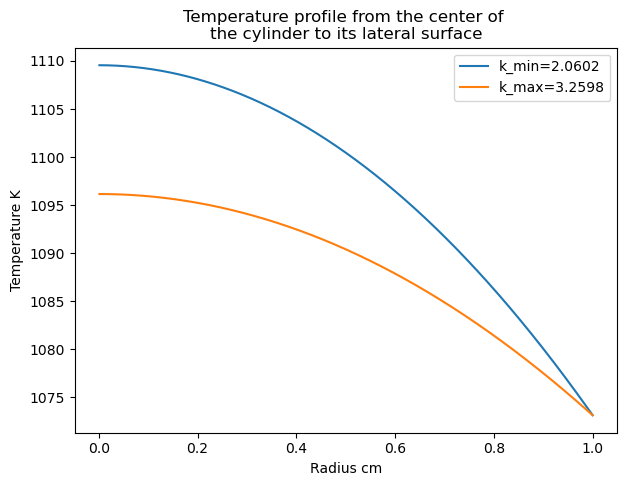

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))

heat_gen = 300
r_max = 1
r = np.linspace(0.001, r_max, resolution)
T_surface = 1073.15

thermal_cond = min_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_min={thermal_cond:.4f}")

thermal_cond = max_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_max={thermal_cond:.4f}")

ax.set_title("Temperature profile from the center of \nthe cylinder to its lateral surface")
ax.set_ylabel('Temperature K')
ax.set_xlabel('Radius cm')
plt.legend()
plt.savefig(f"{path}_profile_korner_cases")

In [12]:
T_max = 4750
T_min = 273.15 + 800
resolution = 1000
T = np.linspace(T_min, T_max, resolution)
cond = k(T)
opt_avg_cond = sum(cond)/len(cond)

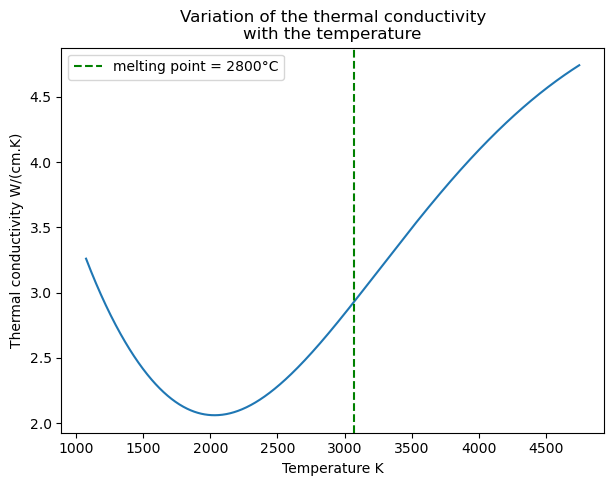

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(T, cond)

plt.axvline(x=2800+273.15, linestyle='--', color='g', label='melting point = 2800°C')
#variation of k(T)
ax.set_title("Variation of the thermal conductivity\nwith the temperature")
ax.set_ylabel('Thermal conductivity W/(cm.K)')
ax.set_xlabel('Temperature K')
plt.legend()
plt.savefig(f"{path}_k1")

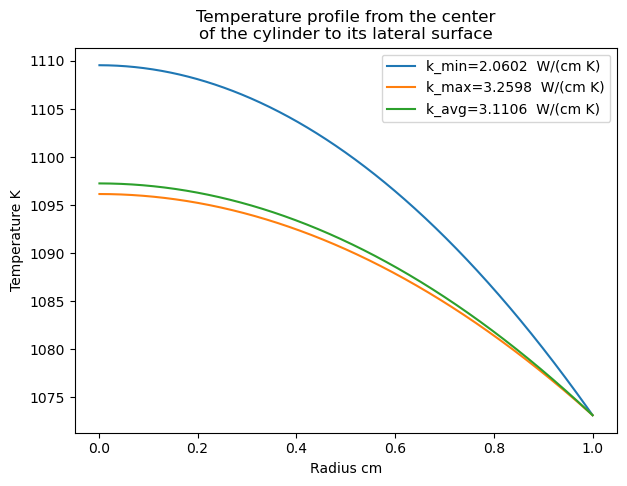

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))

thermal_cond = min_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_min={thermal_cond:.4f}  W/(cm K)")

thermal_cond = max_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_max={thermal_cond:.4f}  W/(cm K)")

thermal_cond = opt_avg_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_avg={thermal_cond:.4f}  W/(cm K)")

ax.set_title("Temperature profile from the center\nof the cylinder to its lateral surface")
ax.set_ylabel('Temperature K')
ax.set_xlabel('Radius cm')
plt.legend()

# Solution with Scipy

In [15]:
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# constants
a = 7.5408e-2
b = 1.7692e-4
c = 3.6142e-8
d = 6.400e9*np.sqrt(1000)
e = 1.635e4
f = 2*c
g = 1.60e8*np.sqrt(1000)
h = 1.0464e12*np.sqrt(1000)

Egen = 300 #W/(cm K)
r_max = 1 #cm
T_surface = 1073.15 #K
k = lambda T : 1/(a + b*T + c*T**2) + d * np.exp(-e/T) / T**(5/2)
# W/(cm*K)
# https://www.nuclear-power.com/nuclear-engineering/heat-transfer/thermal-conduction/thermal-conductivity/thermal-conductivity-of-uranium-dioxide/
k_surface = k(T_surface)

def bvp(r, S):
    T, D, k = S
    dTdr = D
    dkdr = (-(b + f*T) / (a + b*T + c*T**2)**2 
            - g * np.exp(-e/T) / T**(7/2)
            + h * np.exp(-e/T) / T**(9/2)) * D
    dDdr = -(1 / k) * (Egen + D * ( dkdr + k / r))
    return [dTdr, dDdr, dkdr]

def boundary_conditions(boundaries_a, boundaries_b):
    T_a, D_a, k_a = boundaries_a #center boundary
    T_b, D_b, k_b = boundaries_b #surface boundary
    return [T_b - T_surface,
            D_a, #dTdr(r_center) = 0 <=> D(r_center) = 0 
            k_b - k_surface]

In [17]:
T_surface

1073.15

In [18]:
pars_T = np.polyfit([0, .4, 1], [1110, 1100, T_surface], 2) #fit second degree polynomial
T_guess = np.polyval(pars_T, r)

pars_D = np.polyfit([0, 1], [0, -40], 1)
D_guess = np.polyval(pars_D, r)

pars_k = np.polyfit([.3, .8, 1], [k(1110), k(1100), k(T_surface)], 2)
k_guess = np.polyval(pars_k, r)

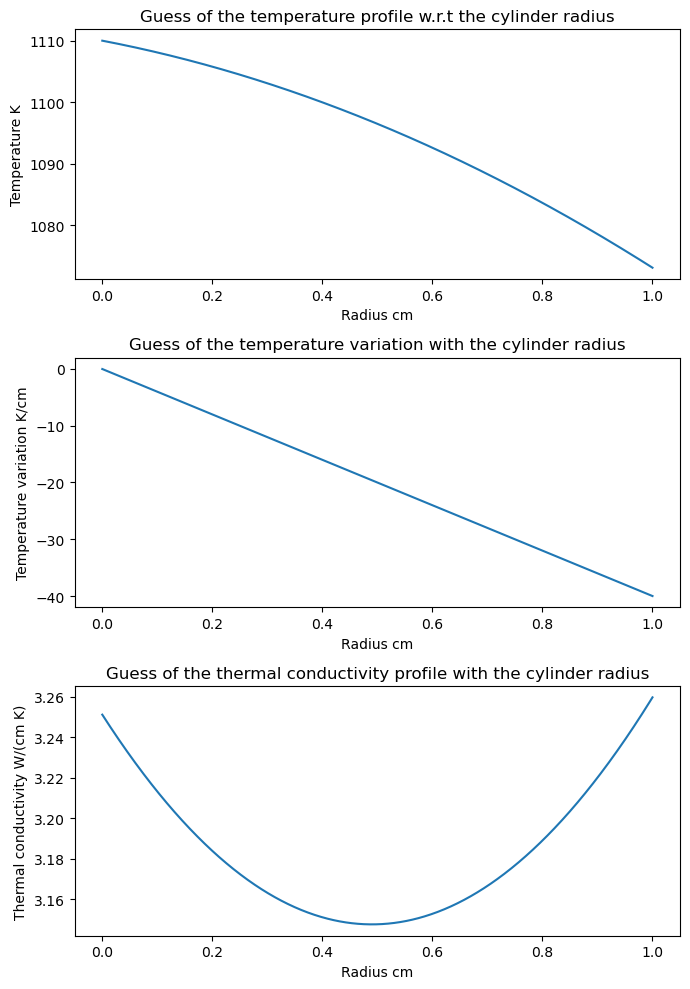

In [19]:
fig, ax = plt.subplots(3, figsize=(7, 10))

ax[0].plot(r, T_guess)
ax[0].set_title("Guess of the temperature profile w.r.t the cylinder radius")
ax[0].set_ylabel('Temperature K')
ax[0].set_xlabel('Radius cm')

ax[1].plot(r, D_guess)
ax[1].set_title("Guess of the temperature variation with the cylinder radius")
ax[1].set_ylabel('Temperature variation K/cm')
ax[1].set_xlabel('Radius cm')

ax[2].plot(r, k_guess)
ax[2].set_title("Guess of the thermal conductivity profile with the cylinder radius")
ax[2].set_ylabel('Thermal conductivity W/(cm K)')
ax[2].set_xlabel('Radius cm')

fig.tight_layout()

In [20]:
sol = solve_bvp(bvp, boundary_conditions, r, [T_guess, D_guess, k_guess])

In [21]:
r_sol = sol.x
T_s, D_s, k_s = sol.y

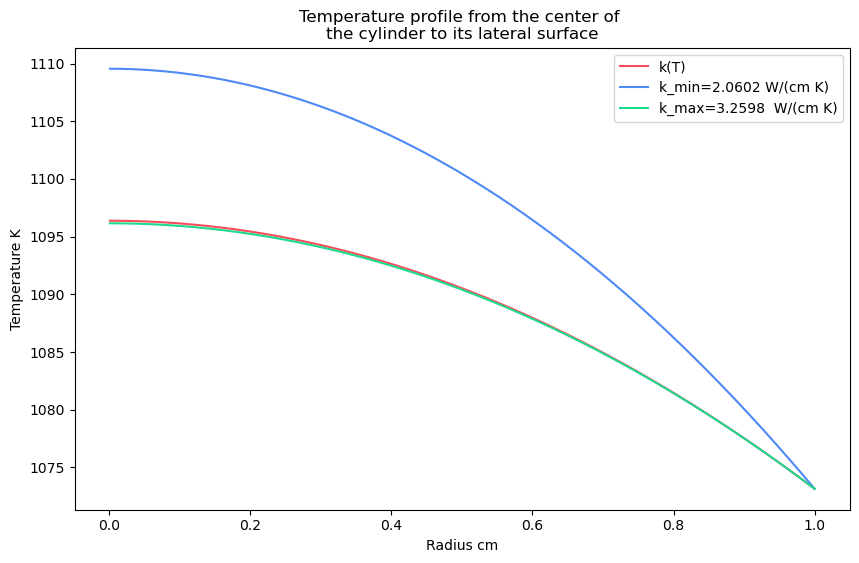

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
c = "#f74d5b"
ax.plot(r_sol, T_s, color=c, label="k(T)")

thermal_cond = min_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_min={thermal_cond:.4f} W/(cm K)", color="#4d89f7")

thermal_cond = max_cond
data = [compute(r_i, T_surface, heat_gen, thermal_cond, r_max) for r_i in r]
ax.plot(r, data, label=f"k_max={thermal_cond:.4f}  W/(cm K)", color="#1ed98e")

ax.set_title("Temperature profile from the center of \nthe cylinder to its lateral surface")
ax.set_ylabel('Temperature K')
ax.set_xlabel('Radius cm')

plt.legend()
plt.savefig(f"{path}T_profiles")

In [ ]:
fig, ax = plt.subplots(3, figsize=(7, 10))

ax[0].plot(r, T_guess, label="guess")
ax[0].plot(r_sol, T_s, label="truth")
ax[0].set_title("Temperature profile w.r.t the cylinder radius")
ax[0].set_ylabel('T K')
ax[0].set_xlabel('Radius cm')
ax[0].legend()

ax[1].plot(r, D_guess, label="guess")
ax[1].plot(r_sol, D_s, label="truth")
ax[1].set_title("Temperature variation with the cylinder radius")
ax[1].set_ylabel('dTdr K/cm')
ax[1].set_xlabel('Radius cm')
ax[1].legend()

ax[2].plot(r, k_guess, label="guess")
ax[2].plot(r_sol, k_s, label="truth")
ax[2].set_title("Thermal conductivity profile with the cylinder radius")
ax[2].set_ylabel('k W/(cm K)')
ax[2].set_xlabel('Radius cm')
ax[2].legend()

fig.tight_layout()
plt.savefig(f"{path}guesses_vs_truth")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
#%matplotlib widget

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={"projection": "3d"})

res = 4*len(r_sol)
theta = np.linspace(-np.pi, np.pi, res)
radius = 1

# Make data.
X = radius * np.cos(theta)
Y = radius * np.sin(theta)

X, Y = np.meshgrid(X, Y)

# T as function of X and Y
R = np.sqrt(X**2 + Y**2)
i = np.array([index-1 for index in (R * len(r_sol) - 1).astype(int)])
i[i > len(r_sol)-1] = len(r_sol)-1
T = np.array([T_s[index] for index in i])
Z = T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.Spectral_r, rstride=10, cstride=10, alpha=.5)

# Add a color bar which maps values to colors.
#cbar_ax = fig.add_axes([0.18, 0, .65, 0.02])
fig.subplots_adjust(right=.5)
plt.colorbar(surf, ax=ax, orientation="vertical", location="left", shrink=.5, pad=-.01)

ax.set_ylabel('lateral dimension cm')
ax.set_xlabel('depth cm')
ax.set_zlabel('Temperature K')
fig.tight_layout()

z = np.linspace(1073, np.max(T), 100)
theta_grid, z_grid=np.meshgrid(theta, z)
x_grid = radius*np.cos(theta_grid)
y_grid = radius*np.sin(theta_grid)

surf = ax.plot_surface(x_grid, y_grid, z_grid, alpha=.05, color='black', label="Cylinder lateral surface")
surf._edgecolors2d = surf._edgecolor3d
surf._facecolors2d = surf._facecolor3d
ax.legend(loc="lower left")

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_title("Temperature profile of the cylinder", fontsize=16, y=1.02, pad=0)
plt.savefig(f"/home/jovyan/work/heat_eq/solution/temp_profile3D")